<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/4_2_Logistic_Regression_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Logistic Regression with Binary and Multiclass Classification

## Introduction
Unlike linear regression, logistic regression models the probability of a target variable belonging to a specific class. It is suitable for both binary and multiclass classification tasks. Logistic regression uses the **sigmoid function** to ensure the output lies between 0 and 1.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

The breast cancer dataset, available [here](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

- **mean radius**: Mean of distances from center to points on the perimeter
- **mean texture**: Standard deviation of gray-scale values
- **mean perimeter**: Mean size of the core tumor perimeter
- **mean area**: Mean size of the core tumor area
- **mean smoothness**: Mean of local variation in radius lengths                |
- Target: **0**: Malignant (Cancerous) or **1**: Benign (Non-Cancerous)


In [2]:
breast_cancer_df = load_breast_cancer(as_frame=True).frame
breast_cancer_df.sample(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
363,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,25.45,117.20,1009.0,0.1338,0.16790,0.16630,0.09123,0.2394,0.06469,1
153,11.15,13.08,70.87,381.9,0.09754,0.05113,0.01982,0.01786,0.1830,0.06105,...,16.30,76.25,440.8,0.1341,0.08971,0.07116,0.05506,0.2859,0.06772,1
56,19.21,18.57,125.50,1152.0,0.10530,0.12670,0.13230,0.08994,0.1917,0.05961,...,28.14,170.10,2145.0,0.1624,0.35110,0.38790,0.20910,0.3537,0.08294,0


Visualization of 2 features and their relationship with the label.

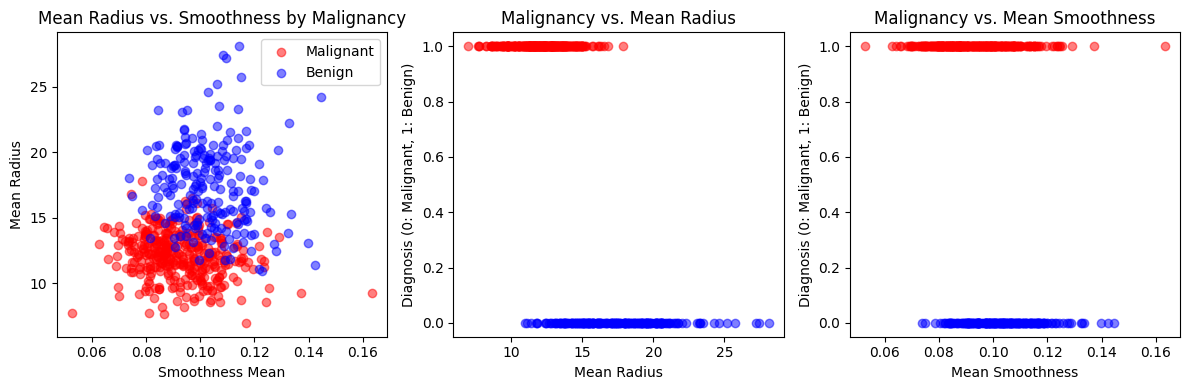

In [3]:
mal = breast_cancer_df[breast_cancer_df["target"] == 1]
ben = breast_cancer_df[breast_cancer_df["target"] == 0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].scatter(mal['mean smoothness'], mal['mean radius'], color='red', alpha=0.5, label='Malignant')
axes[0].scatter(ben['mean smoothness'], ben['mean radius'], color='blue', alpha=0.5, label='Benign')
axes[0].set_xlabel('Smoothness Mean')
axes[0].set_ylabel('Mean Radius')
axes[0].set_title('Mean Radius vs. Smoothness by Malignancy')
axes[0].legend()

axes[1].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')
axes[1].set_xlabel('Mean Radius')
axes[1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1].set_title('Malignancy vs. Mean Radius')

axes[2].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[2].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')
axes[2].set_xlabel('Mean Smoothness')
axes[2].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[2].set_title('Malignancy vs. Mean Smoothness')

plt.tight_layout()
plt.show()

A Linear Regression cannot capture the relationship between these variables and the label.

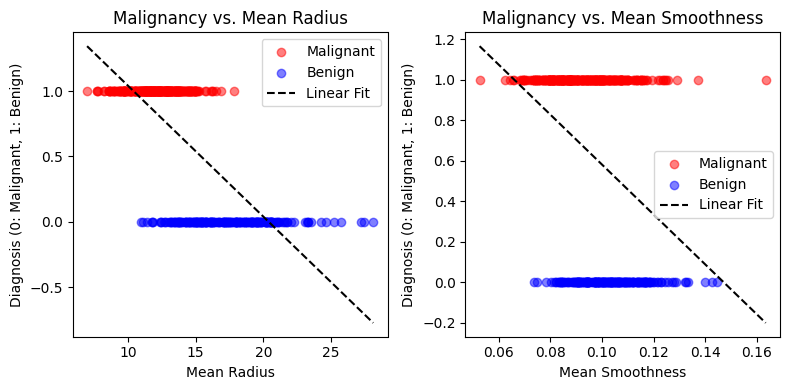

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[0].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100)
y_vals = np.poly1d(np.polyfit(breast_cancer_df['mean radius'], breast_cancer_df['target'], 1))(x_vals)
axes[0].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Linear Fit')

axes[0].set_xlabel('Mean Radius')
axes[0].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[0].set_title('Malignancy vs. Mean Radius')
axes[0].legend()

axes[1].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100)
y_vals = np.poly1d(np.polyfit(breast_cancer_df['mean smoothness'], breast_cancer_df['target'], 1))(x_vals)
axes[1].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Linear Fit')

axes[1].set_xlabel('Mean Smoothness')
axes[1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1].set_title('Malignancy vs. Mean Smoothness')
axes[1].legend()

plt.tight_layout()
plt.show()


## Logistic Regression


We prepare our data

In [5]:
from sklearn.preprocessing import StandardScaler

X = breast_cancer_df[['mean radius']].values
y = breast_cancer_df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(breast_cancer_df[['mean radius']])
breast_cancer_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Sigmoid Function

The logistic (sigmoid) function maps any real-valued number into the range $(0,1) $:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

where $z $ is the linear combination of weights and input features:

$$
z = \beta_0 + \sum_j \beta_j x_{ij}
$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Maximum Likelihood Estimation (MLE)

We estimate the parameters $\beta $ by maximizing the likelihood function:

$$
L(\beta) = \prod_{i=1}^{m} p(X_i)^{y_i} (1 - p(X_i))^{(1 - y_i)}
$$

Taking the logarithm for computational efficiency:

$$
\log L(\beta) = \sum_{i=1}^{m} y_i \log p(X_i) + (1 - y_i) \log (1 - p(X_i))
$$

To find the optimal values of $\beta $, we compute the gradient:

$$
\frac{\partial \log L}{\partial \beta_j} = \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

Using gradient descent, we iteratively update the weights:

$$
\beta_j := \beta_j + \alpha \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

where:
- $\alpha $ is the learning rate.
- The term $(y_i - p(X_i)) $ represents the error between the true label and the predicted probability.

In [7]:
def compute_log_likelihood(X, y, betas):
    h = sigmoid(X @ betas)
    return np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

### Gradient Ascent for Logistic Regression

To optimize $J(\beta) $ (log-likelihood), we use **gradient ascent**:

$$
\beta := \beta + \alpha \frac{\partial \log L}{\partial \beta}
$$

which updates the parameters iteratively to **maximize** the log-likelihood function:

$$
\log L(\beta) = \sum_{i=1}^{m} y_i \log p(X_i) + (1 - y_i) \log (1 - p(X_i))
$$

where:

$$
\frac{\partial \log L}{\partial \beta_j} = \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

The update rule for **gradient ascent** is:

$$
\beta_j := \beta_j + \alpha \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

where:
- $\alpha $ is the learning rate.
- $(y_i - p(X_i)) $ is the error term.
- $x_{ij} $ are the feature values.

This process ensures the parameters are updated iteratively to **maximize** the log-likelihood function.


In [8]:
from tqdm.notebook import tqdm
np.seterr(divide='raise', invalid='raise')

def gradient_ascent_mle(X, y, betas, learning_rate=0.01, epochs=100, clip_value=1):
    log_likelihood_history = []
    for _ in tqdm(range(epochs)):
      try:
        h = sigmoid(X @ betas)
        gradient = X.T @ (y - h)
        gradient = np.clip(gradient, -clip_value, clip_value)  # Exploding Gradient
        betas += learning_rate * gradient
        log_likelihood_history.append(compute_log_likelihood(X, y, betas))
      except Exception as e:
        print(f"Error in GA: {e}, X: {X}, betas:{betas}")
        break
    return betas, log_likelihood_history

We train our gradient ascent and find the betas.

Note the plot—where it plateaus, we know it's the optimal number of iterations.  
MLE is negative, and the more samples it has, the more negative it becomes.  
MLE should become less negative with training.


  0%|          | 0/10000 [00:00<?, ?it/s]

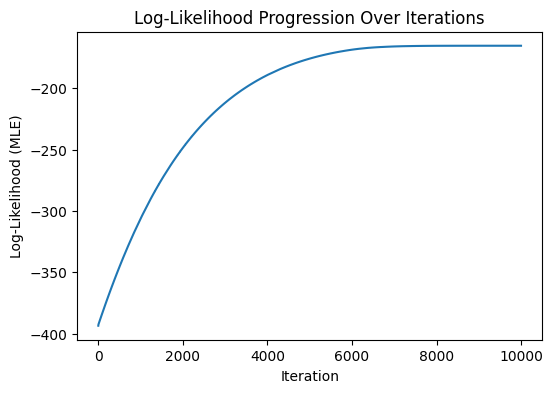

array([14.06451003, -0.94901884])

In [9]:
X_bias = np.column_stack((np.ones(X_scaled.shape[0]), X))
betas = np.random.normal(loc=0, scale=0.01, size=(X_bias.shape[1]))
betas_opt_mle, log_likelihood_history = gradient_ascent_mle(X_bias,
                                                            y,
                                                            betas,
                                                            learning_rate=0.002,
                                                            epochs=10000)

plt.figure(figsize=(6, 4))
plt.plot(range(len(log_likelihood_history)), log_likelihood_history)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood (MLE)")
plt.title("Log-Likelihood Progression Over Iterations")
plt.show()

betas_opt_mle

### Predict with Logistic Regression

The probability of the target belonging to class 1, given the input features $X $, is given by:

$$
p(X) = \frac{\exp(\beta_0 + \sum_j \beta_j x_{ij})}{1 + \exp(\beta_0 + \sum_j \beta_j x_{ij})}
$$

where:
- $p(X) $ is the probability that the instance belongs to class 1.
- $\beta_0 $ is the intercept (bias).
- $\beta_j $ are the coefficients (weights).
- $x_{ij} $ represents the feature values.



In [10]:
def predict(X, betas):
    return sigmoid(X @ betas) >= 0.5

predictions = predict(X_bias, betas_opt_mle)
accuracy = np.mean(predictions == y)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8822


# Classification Metrics Formulas

Accuracy
$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$

Precision
$
Precision = \frac{TP}{TP + FP}
$

Recall (Sensitivity)
$
Recall = \frac{TP}{TP + FN}
$

Specificity
$
Specificity = \frac{TN}{TN + FP}
$

F1-Score
$
F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}
$

ROC Curve Components
$
TPR = \frac{TP}{TP + FN}
$
$
FPR = \frac{FP}{FP + TN}
$

AUC (Area Under the Curve)
$
AUC = \int_{0}^{1} TPR \, d(FPR)
$


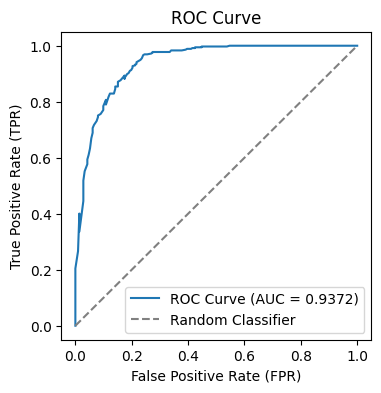

,Metric,Value
0,Accuracy,0.882250
1,Precision,0.879581
2,Recall (Sensitivity),0.941176
3,Specificity,0.783019
4,F1-Score,0.909337
5,AUC,0.937213


In [11]:
def get_classification_metrics(predictions, y, X_bias, betas_opt_mle):
    TP = np.sum((predictions == 1) & (y == 1))
    TN = np.sum((predictions == 0) & (y == 0))
    FP = np.sum((predictions == 1) & (y == 0))
    FN = np.sum((predictions == 0) & (y == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    thresholds = np.linspace(0, 1, 100)
    tpr_values = []
    fpr_values = []

    for t in thresholds:
        predictions_t = sigmoid(X_bias @ betas_opt_mle) >= t
        TP_t = np.sum((predictions_t == 1) & (y == 1))
        TN_t = np.sum((predictions_t == 0) & (y == 0))
        FP_t = np.sum((predictions_t == 1) & (y == 0))
        FN_t = np.sum((predictions_t == 0) & (y == 1))

        tpr_values.append(TP_t / (TP_t + FN_t) if (TP_t + FN_t) > 0 else 0)
        fpr_values.append(FP_t / (FP_t + TN_t) if (FP_t + TN_t) > 0 else 0)

    sorted_indices = np.argsort(fpr_values)
    fpr_values = np.array(fpr_values)[sorted_indices]
    tpr_values = np.array(tpr_values)[sorted_indices]
    auc = np.trapz(tpr_values, x=fpr_values)  # Approx trapezoidal rule

    metrics = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "F1-Score", "AUC"],
        "Value": [accuracy, precision, recall, specificity, f1_score, auc],
    })

    return metrics, tpr_values, fpr_values

metrics, tpr_values, fpr_values = get_classification_metrics(predictions, y, X_bias, betas_opt_mle)

plt.figure(figsize=(4, 4))
plt.plot(fpr_values, tpr_values, linestyle='-', label=f'ROC Curve (AUC = {metrics.loc[metrics["Metric"] == "AUC", "Value"].values[0]:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

metrics

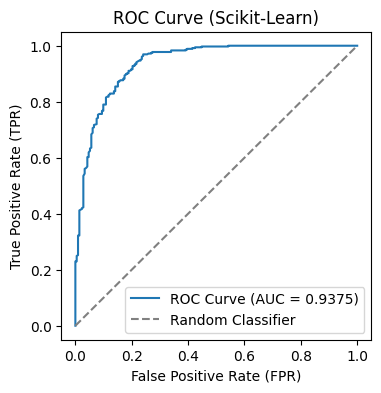

,Metric,Value
0,Accuracy,0.878735
1,Precision,0.880952
2,Recall (Sensitivity),0.932773
3,Specificity,NaN
4,F1-Score,0.906122
5,AUC,0.937517


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score


log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)


y_pred = log_reg.predict(X)
y_pred_prob = log_reg.predict_proba(X)[:, 1]


accuracy_sklearn = accuracy_score(y, y_pred)
precision_sklearn = precision_score(y, y_pred)
recall_sklearn = recall_score(y, y_pred)
f1_sklearn = f1_score(y, y_pred)

fpr_sklearn, tpr_sklearn, _ = roc_curve(y, y_pred_prob)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)
metrics_sklearn = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "F1-Score", "AUC"],
    "Value": [accuracy_sklearn, precision_sklearn, recall_sklearn, np.nan, f1_sklearn, auc_sklearn],
})


plt.figure(figsize=(4, 4))
plt.plot(fpr_sklearn, tpr_sklearn, linestyle='-', label=f'ROC Curve (AUC = {auc_sklearn:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Scikit-Learn)')
plt.legend()
plt.show()

metrics_sklearn

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


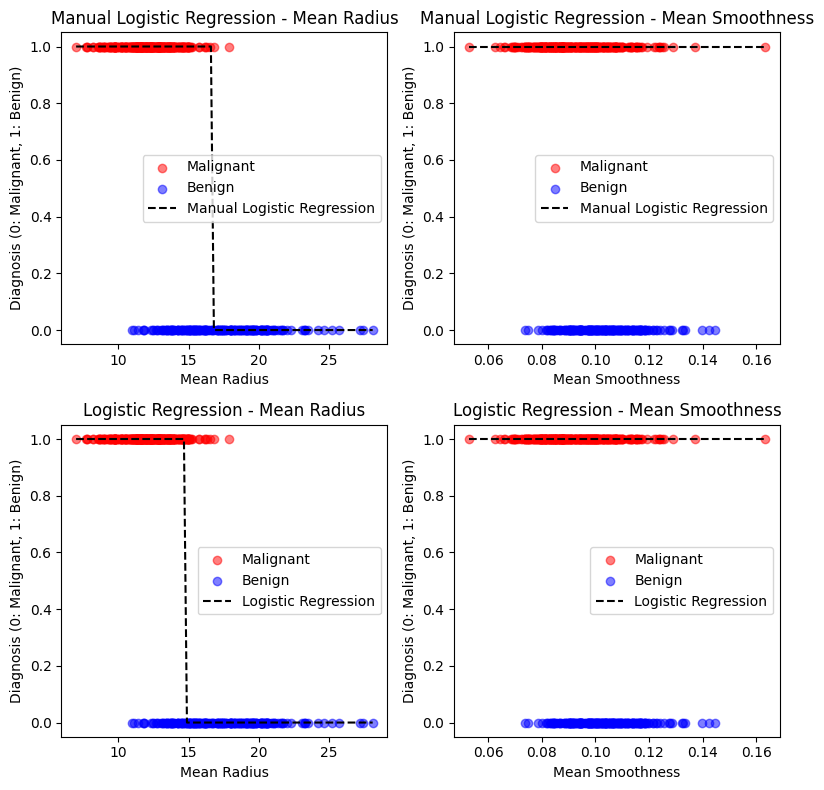

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Manually Implemented Logistic Regression - Mean Radius
X_radius = breast_cancer_df[['mean radius']].values
X_radius_bias = np.c_[np.ones(X_radius.shape[0]), X_radius]
betas_radius = np.zeros(X_radius_bias.shape[1])
betas_opt_radius, _ = gradient_ascent_mle(X_radius_bias, y, betas_radius)

axes[0, 0].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[0, 0].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100)
y_vals = predict(np.c_[np.ones(len(x_vals)), x_vals], betas_opt_radius).astype(int)

axes[0, 0].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Manual Logistic Regression')
axes[0, 0].set_xlabel('Mean Radius')
axes[0, 0].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[0, 0].set_title('Manual Logistic Regression - Mean Radius')
axes[0, 0].legend()

# Manually Implemented Logistic Regression - Mean Smoothness
X_smooth = breast_cancer_df[['mean smoothness']].values
X_smooth_bias = np.c_[np.ones(X_smooth.shape[0]), X_smooth]
betas_smooth = np.zeros(X_smooth_bias.shape[1])
betas_opt_smooth, _ = gradient_ascent_mle(X_smooth_bias, y, betas_smooth)

axes[0, 1].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[0, 1].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100)
y_vals = predict(np.c_[np.ones(len(x_vals)), x_vals], betas_opt_smooth).astype(int)

axes[0, 1].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Manual Logistic Regression')
axes[0, 1].set_xlabel('Mean Smoothness')
axes[0, 1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[0, 1].set_title('Manual Logistic Regression - Mean Smoothness')
axes[0, 1].legend()

# Scikit-Learn Logistic Regression - Mean Radius
log_reg_radius = LogisticRegression(solver='lbfgs')
log_reg_radius.fit(breast_cancer_df[['mean radius']], y)

axes[1, 0].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1, 0].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100).reshape(-1, 1)
y_vals = log_reg_radius.predict(x_vals)

axes[1, 0].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Logistic Regression')
axes[1, 0].set_xlabel('Mean Radius')
axes[1, 0].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1, 0].set_title('Logistic Regression - Mean Radius')
axes[1, 0].legend()

# Scikit-Learn Logistic Regression - Mean Smoothness
log_reg_smooth = LogisticRegression(solver='lbfgs')
log_reg_smooth.fit(breast_cancer_df[['mean smoothness']], y)

axes[1, 1].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1, 1].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100).reshape(-1, 1)
y_vals = log_reg_smooth.predict(x_vals)

axes[1, 1].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Logistic Regression')
axes[1, 1].set_xlabel('Mean Smoothness')
axes[1, 1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1, 1].set_title('Logistic Regression - Mean Smoothness')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

As a 3D regression. In this one we will do a multivariable regression using both mean radius and smoothness combines.

In [14]:
X = breast_cancer_df[['mean radius', 'mean smoothness']].values
y = breast_cancer_df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
breast_cancer_df.describe()

X_bias_scaled = np.column_stack((np.ones(X_scaled.shape[0]), X_scaled))

betas = np.random.normal(loc=0, scale=0.01, size=(X_bias_scaled.shape[1]))
betas_opt_features, log_likelihood_history_features = gradient_ascent_mle(X_bias_scaled, y, betas)
betas_opt_features

  0%|          | 0/100 [00:00<?, ?it/s]

array([ 0.64737691, -1.01884265, -0.81252721])

We show the decision boundary.

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


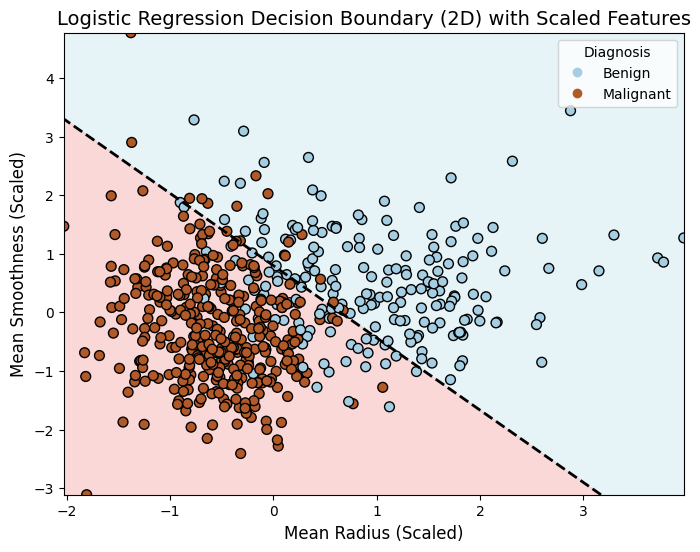

In [15]:
betas_opt_features_scaled, _ = gradient_ascent_mle(X_bias_scaled, y, np.zeros(X_bias_scaled.shape[1]))
betas_opt_features_scaled = np.array(betas_opt_features_scaled).astype(float).flatten()

radius_vals_scaled = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 100)
smoothness_vals_scaled = np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 100)
radius_mesh_scaled, smoothness_mesh_scaled = np.meshgrid(radius_vals_scaled, smoothness_vals_scaled)

X_mesh_scaled = np.column_stack((np.ones(radius_mesh_scaled.size), radius_mesh_scaled.ravel(), smoothness_mesh_scaled.ravel()))
z_vals_scaled = sigmoid(X_mesh_scaled @ betas_opt_features_scaled).reshape(radius_mesh_scaled.shape)

plt.figure(figsize=(8, 6))
plt.contourf(radius_mesh_scaled, smoothness_mesh_scaled, z_vals_scaled, levels=[0, 0.5, 1], colors=['lightblue', 'lightcoral'], alpha=0.3)
plt.contour(radius_mesh_scaled, smoothness_mesh_scaled, z_vals_scaled, levels=[0.5], colors='black', linewidths=2, linestyles='dashed')

X_transformed = scaler.transform(breast_cancer_df[['mean radius', 'mean smoothness']])
y_pred_scaled = (sigmoid(X_bias_scaled @ betas_opt_features_scaled) >= 0.5).astype(int)
class_labels = ["Malignant", "Benign"]

scatter =plt.scatter(
        X_transformed[:, 0],
        X_transformed[:, 1],
        c=y,
        cmap=plt.cm.Paired,
        edgecolors="black",
        s=50,
        marker="o",
    )
legend_labels = ["Benign", "Malignant"]
plt.legend(
        scatter.legend_elements()[0],
        legend_labels,
        loc="upper right",
        title="Diagnosis",
    )

plt.xlabel('Mean Radius (Scaled)', fontsize=12)
plt.ylabel('Mean Smoothness (Scaled)', fontsize=12)
plt.title('Logistic Regression Decision Boundary (2D) with Scaled Features', fontsize=14)

plt.show()

This code was taken from our first notebook introduction to ML and AI.

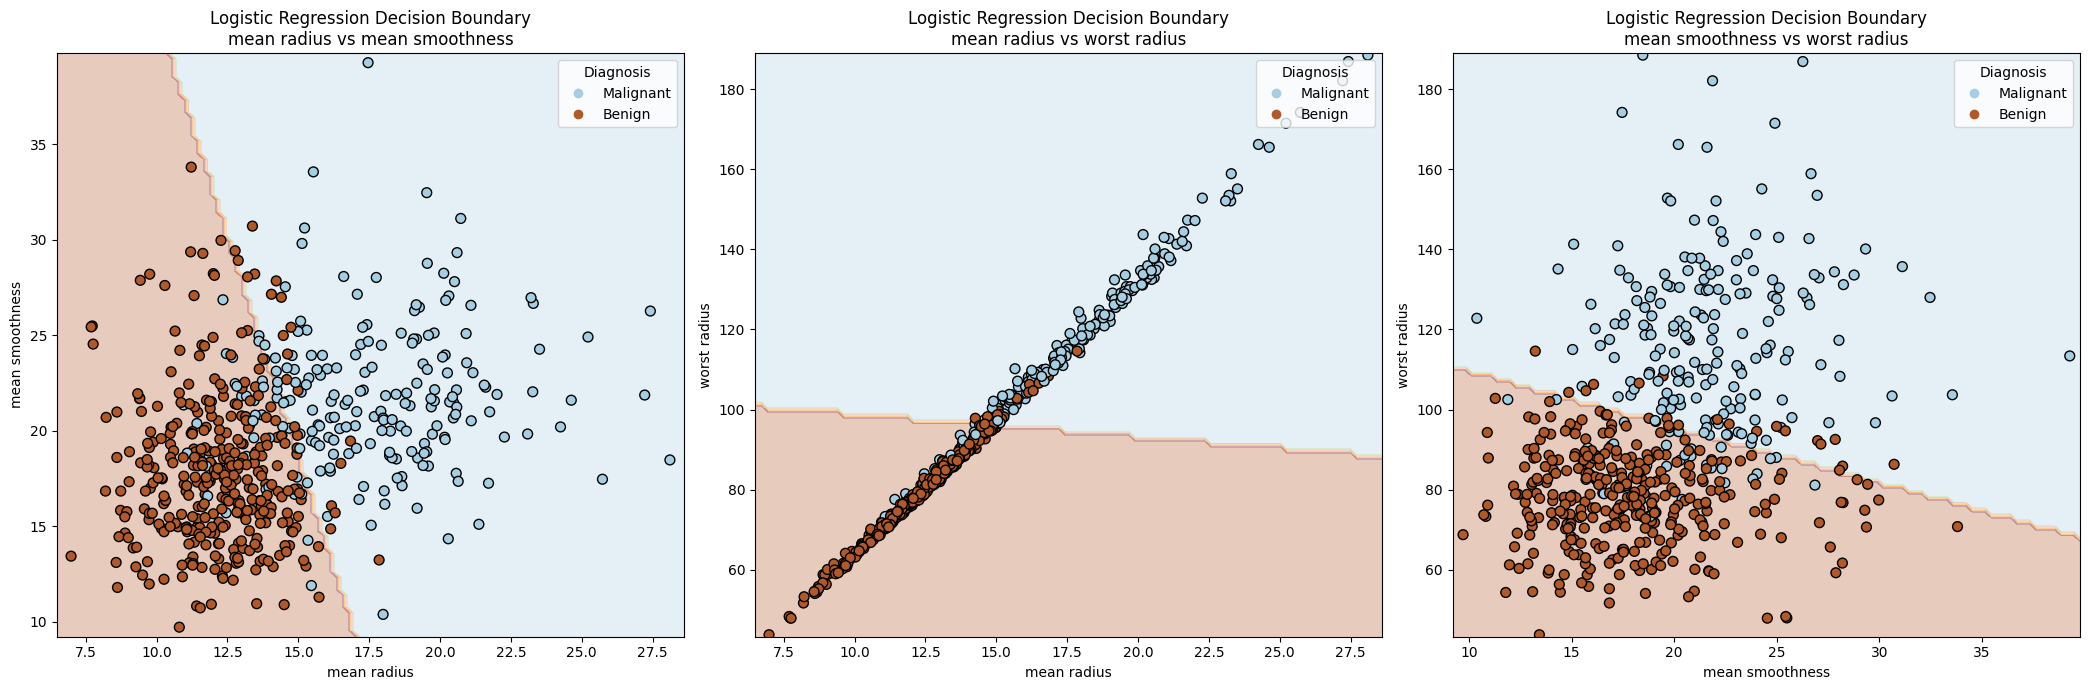

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

def plot_logistic_decision_boundary(X, y, ax, feature_names, class_labels):
    model = make_pipeline(StandardScaler(), LogisticRegression()).fit(X, y)
    common_params = {"estimator": model, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="contourf",
        cmap=plt.cm.Paired,
        alpha=0.3,
        eps=0.5,
    )
    scatter = ax.scatter(
        X.iloc[:, 0],
        X.iloc[:, 1],
        c=y,
        cmap=plt.cm.Paired,
        edgecolors="black",
        s=50,
        marker="o",
    )
    legend_labels = [class_labels[int(label)] for label in np.unique(y)]
    ax.legend(
        scatter.legend_elements()[0],
        legend_labels,
        loc="upper right",
        title="Diagnosis",
    )

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(f"Logistic Regression Decision Boundary\n{feature_names[0]} vs {feature_names[1]}")

feature_labels = ["mean radius", "mean smoothness", "worst radius"]
feature_combinations = [
    (0, 1, ["mean radius", "mean smoothness"]),
    (0, 2, ["mean radius", "worst radius"]),
    (1, 2, ["mean smoothness", "worst radius"]),
]

fig, axes = plt.subplots(1, 3, figsize=(21, 7), tight_layout=True)
for ax, (idx1, idx2, names) in zip(axes, feature_combinations):
    X_pair = breast_cancer_df.iloc[:, [idx1, idx2]]
    y_pair = breast_cancer_df["target"]
    plot_logistic_decision_boundary(X_pair, y_pair, ax, names, class_labels)

plt.show()

## Imbalanced Dataset Regression

The dataset from scikit learn is mostly balanced. We have prepared one for you, the EU fraudulent credit card transactions. Download it from [here](https://drive.google.com/file/d/18beByqf2acT8CQdrMfaQTgCozRLpN94E/view?usp=sharing).

The dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available [on] (https://www.researchgate.net/project/Fraud-detection-5) and the page of the DefeatFraud project

In [17]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/creditcard.csv"
creditcard_df = pd.read_csv(file_path)

creditcard_df.describe()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


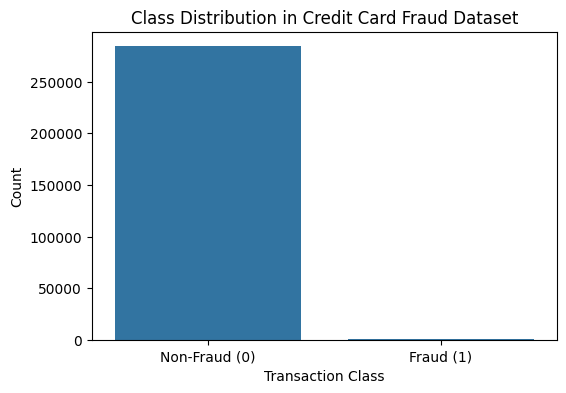

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

class_counts = creditcard_df['Class'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"])
plt.xlabel("Transaction Class")
plt.ylabel("Count")
plt.title("Class Distribution in Credit Card Fraud Dataset")
plt.show()

In [19]:
X = creditcard_df.drop(columns=['Class', 'Time'])
y = creditcard_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_bias_train = np.column_stack((np.ones(X_train_scaled.shape[0]), X_train_scaled))
X_bias_test = np.column_stack((np.ones(X_test_scaled.shape[0]), X_test_scaled))

print(f"Shapes: {X_bias_test.shape}, {y_test.shape}")

betas = np.random.normal(loc=0, scale=0.01, size=X_bias_train.shape[1])
betas_opt_mle, log_likelihood_history = gradient_ascent_mle(X_bias_train,
                                                            y_train,
                                                            betas,
                                                            learning_rate=0.0045,
                                                            epochs=100)

Shapes: (56962, 30), (56962,)


  0%|          | 0/100 [00:00<?, ?it/s]

Error in GA: divide by zero encountered in log, X: [[ 1.          0.99337908 -0.45603659 ...  0.19191152 -0.09910576
  -0.32249376]
 [ 1.          1.03850725 -0.02934912 ...  0.00639701 -0.21152423
  -0.33976388]
 [ 1.         -0.50676613  0.36606499 ...  0.09413695  0.56642647
   0.34669349]
 ...
 [ 1.          0.54569899  0.04401572 ...  0.07676455  0.07564817
  -0.17053266]
 [ 1.          0.65325241  0.18256566 ... -0.14759091 -0.0184768
  -0.34813969]
 [ 1.         -0.30573748  0.47027277 ...  0.93509494  0.63073809
  -0.32380996]], betas:[-0.37887031 -0.14522267  0.11894612 -0.25354743  0.1450353  -0.15428954
 -0.05423732 -0.26203787  0.05547146 -0.11260089 -0.2695692   0.17486188
 -0.31229215  0.00601556 -0.30998067 -0.00837711 -0.25607736 -0.38011197
 -0.16228869  0.0475591   0.03019862  0.02929614  0.00091351 -0.0058954
 -0.0037779   0.00461059  0.00328756  0.01984888  0.00477559  0.00523906]


Here we have hit one of the described troubles in training a model, the stability of the coefficients. The gradient is growinng too large or too small, if its 1,  P minus 1 is 0, or if P is 0, and log 0 is infinite!

we should either clip or regularize!

In [20]:
def debug_compute_log_likelihood(X, y, betas):
    eps = 1e-10  # Small epsilon to avoid log(0)
    h = sigmoid(X @ betas)
    h = np.maximum(np.full(h.shape, eps), np.minimum(np.full(h.shape, 1-eps), h))
    print(f"Min h: {h.min()}, Max h: {h.max()}")

    return np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))


def gradient_ascent_mle_l2(X, y, betas, learning_rate, epochs, reg_lambda, clip_value=1):
    log_likelihood_history = []
    for _ in tqdm(range(epochs)):
        try:
            h = sigmoid(X @ betas)
            # Compute gradient with L2 regularization, not on bias!
            gradient = X.T @ (y - h)
            gradient = np.clip(gradient, -clip_value, clip_value)
            betas[1:] += learning_rate * (gradient[1:] - reg_lambda * betas[1:])

            log_likelihood_history.append(debug_compute_log_likelihood(X, y, betas))
        except Exception as e:
            print(f"Error in GA: {e}, X: {X}, betas:{betas}")
            break

    return betas, log_likelihood_history

betas = np.random.normal(loc=0, scale=0.05, size=X_bias_train.shape[1])

betas_opt_mle, log_likelihood_history = gradient_ascent_mle_l2(X_bias_train,
                                                               y_train,
                                                               betas,
                                                               learning_rate=0.0045,
                                                               epochs=100,
                                                               reg_lambda=0.1)
y_pred = predict(X_bias_test, betas_opt_mle)

print(f"Shapes: {y_pred.shape}, {y_test.shape}")
accuracy_score(y_pred, y_test)

  0%|          | 0/100 [00:00<?, ?it/s]

Min h: 1.8651821125467803e-05, Max h: 0.9990957844068683
Min h: 4.264115723660578e-05, Max h: 0.9983886583677897
Min h: 9.2822638012862e-05, Max h: 0.9915906979496376
Min h: 0.00020458651797214506, Max h: 0.9856657217899375
Min h: 0.0003962835095784175, Max h: 0.9737145884119327
Min h: 0.000892236988958736, Max h: 0.952112060485578
Min h: 0.001833561110471895, Max h: 0.9499414870501443
Min h: 0.0038102811903092094, Max h: 0.965359285923125
Min h: 0.008229320211758264, Max h: 0.9674694713752472
Min h: 0.012833332463394513, Max h: 0.977980511263507
Min h: 0.022901106881101665, Max h: 0.9806443992674913
Min h: 0.03696599871862799, Max h: 0.9854136990710669
Min h: 0.06042747520406708, Max h: 0.9866525456784543
Min h: 0.07770821532395937, Max h: 0.9877065847308073
Min h: 0.14435661804588484, Max h: 0.9916312877610823
Min h: 0.1773938100735307, Max h: 0.9969236523904117
Min h: 0.1819269689032308, Max h: 0.9977898591037401
Min h: 0.28850073094536033, Max h: 0.9985709203762833
Min h: 0.2649057

0.9708226536989571

## Instable Learning

Almost 83% looks accurate!


But, remember from our lessons on having an imbalanced dataset.

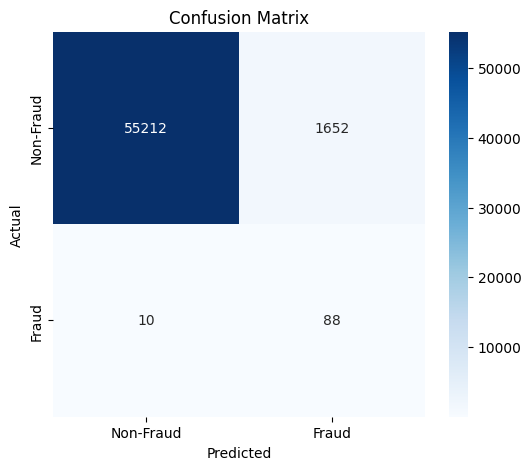

,precision,recall,f1-score,support
Non-Fraud,0.999819,0.970948,0.985172,56864.000000
Fraud,0.050575,0.897959,0.095756,98.000000
accuracy,0.970823,0.970823,0.970823,0.970823
macro avg,0.525197,0.934454,0.540464,56962.000000
weighted avg,0.998186,0.970823,0.983642,56962.000000


In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"], output_dict=True)
df_class_report = pd.DataFrame(class_report).T
df_class_report

## Balance the Dataset

From Data engineering we use SMOTE

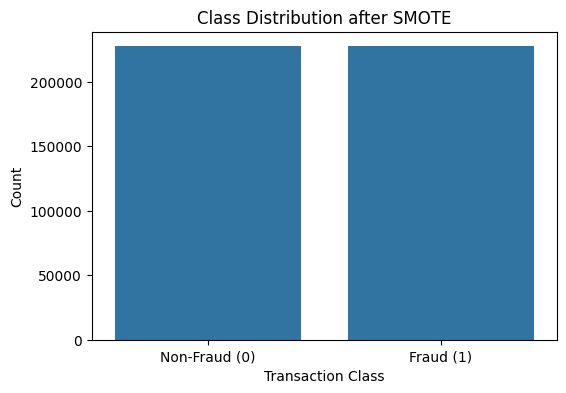

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
X_resampled = np.column_stack((np.ones(X_resampled.shape[0]), X_resampled))
class_counts = y_resampled.value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"])
plt.xlabel("Transaction Class")
plt.ylabel("Count")
plt.title("Class Distribution after SMOTE")
plt.show()

  0%|          | 0/350 [00:00<?, ?it/s]

Min h: 0.008212598472781454, Max h: 0.9999927198520362
Min h: 0.035509878159147266, Max h: 0.9999983177753243
Min h: 0.031076958904432333, Max h: 0.9999898678349329
Min h: 0.0018690558683216094, Max h: 0.999998523298405
Min h: 9.016313066581887e-05, Max h: 0.9999996318803733
Min h: 0.007831082975385775, Max h: 0.9999999969758735
Min h: 0.06982807398118705, Max h: 0.999999987640462
Min h: 0.005081572227157644, Max h: 0.9999999984537586
Min h: 0.13280996474214363, Max h: 0.9999999983894665
Min h: 0.023611022664236456, Max h: 0.9999999995762432
Min h: 0.05651111901933194, Max h: 0.9999999998617528
Min h: 0.08794492970971961, Max h: 0.9999999999
Min h: 0.07517175926585587, Max h: 0.9999999999
Min h: 0.037621031424156536, Max h: 0.9999999999
Min h: 0.04046756731740594, Max h: 0.9999999999
Min h: 0.024576062968534717, Max h: 0.9999999999
Min h: 0.041441077153129495, Max h: 0.9999999999
Min h: 0.025082291202348502, Max h: 0.9999999999
Min h: 0.03198331996666947, Max h: 0.9999999999
Min h: 0.0

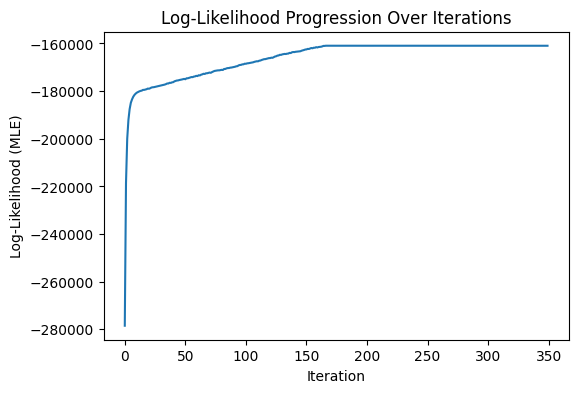

Shapes: (56962,), (56962,)


0.7247638776728346

In [23]:
betas = np.random.normal(loc=0, scale=0.05, size=X_bias_train.shape[1])

betas_opt_mle, log_likelihood_history = gradient_ascent_mle_l2(X_resampled,
                                                               y_resampled,
                                                               betas,
                                                               learning_rate=0.03,
                                                               epochs=350,
                                                               reg_lambda=0.0001)
y_pred = predict(X_bias_test, betas_opt_mle)

plt.figure(figsize=(6, 4))
plt.plot(range(len(log_likelihood_history)), log_likelihood_history)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood (MLE)")
plt.title("Log-Likelihood Progression Over Iterations")
plt.show()

print(f"Shapes: {y_pred.shape}, {y_test.shape}")
accuracy_score(y_pred, y_test)

Check again the FPs.

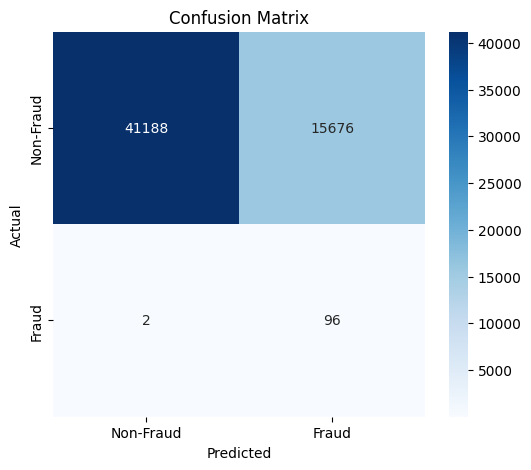

,precision,recall,f1-score,support
Non-Fraud,0.999951,0.724325,0.840109,56864.000000
Fraud,0.006087,0.979592,0.012098,98.000000
accuracy,0.724764,0.724764,0.724764,0.724764
macro avg,0.503019,0.851958,0.426103,56962.000000
weighted avg,0.998242,0.724764,0.838684,56962.000000


In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"], output_dict=True)
df_class_report = pd.DataFrame(class_report).T
df_class_report

## Validate with Scikit

In [25]:
X = creditcard_df.drop(columns=['Class', 'Time'])
y = creditcard_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

model = make_pipeline(StandardScaler(), LogisticRegression()).fit(X_train, y_train)
y_pred = predict(X_bias_test, betas_opt_mle)
accuracy_score(y_pred, y_test)

0.7247638776728346

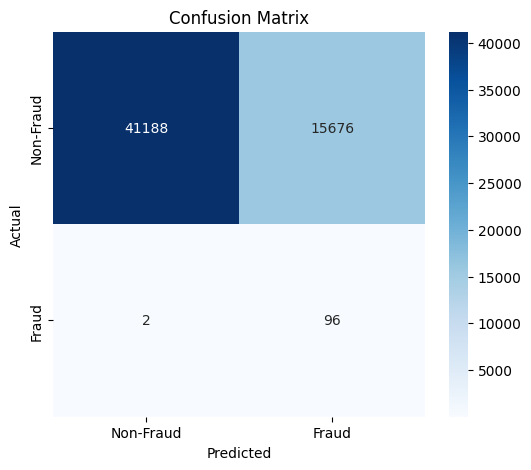

,precision,recall,f1-score,support
Non-Fraud,0.999951,0.724325,0.840109,56864.000000
Fraud,0.006087,0.979592,0.012098,98.000000
accuracy,0.724764,0.724764,0.724764,0.724764
macro avg,0.503019,0.851958,0.426103,56962.000000
weighted avg,0.998242,0.724764,0.838684,56962.000000


In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"], output_dict=True)
df_class_report = pd.DataFrame(class_report).T
df_class_report

We detect all frauds, but, we have too many FP, which means we might lose clients if we accuse them of fraud!

let's try to increase the threshold.

In [27]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.999).astype(int)

accuracy_score(y_pred, y_test)

0.9990344440153085

## Precision-Recall Curve

We can use a curve to find the best threshold value.

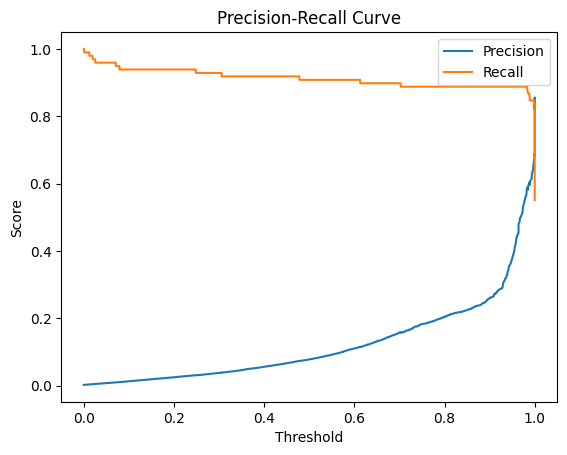

0.9721022344687983

In [28]:
from sklearn.metrics import precision_recall_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

best_threshold = thresholds[np.argmax(precision >= 0.51)]
best_threshold

In [29]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.999).astype(int)

accuracy_score(y_pred, y_test)

0.9990344440153085

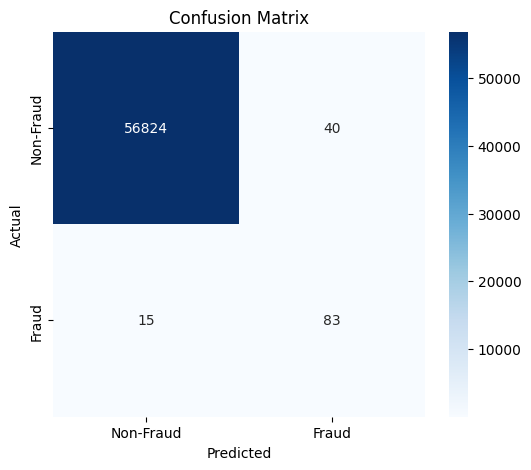

,precision,recall,f1-score,support
Non-Fraud,0.999736,0.999297,0.999516,56864.000000
Fraud,0.674797,0.846939,0.751131,98.000000
accuracy,0.999034,0.999034,0.999034,0.999034
macro avg,0.837266,0.923118,0.875324,56962.000000
weighted avg,0.999177,0.999034,0.999089,56962.000000


In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"], output_dict=True)
df_class_report = pd.DataFrame(class_report).T
df_class_report

# Conclussion

In this notebook, you have applied your Logistic Regression learning.
You can manually model a learning regression function, build its gradient descent, calculate its performance metrics, and understand issues on numerical instability and imbalanced datasets.

See you in the next, on gradient descent!